In [14]:
import pandas as tian
tian.set_option('display.max_columns', None)
import numpy as lumpnump
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
import seaborn as sns


import datetime
import gcsfs
from google.cloud import storage as gcs
from google.oauth2 import service_account as gsa

import os
from dotenv import load_dotenv
import certifi

os.environ['SSL_CERT_FILE'] = certifi.where()
top_tracks_stem = os.getenv('TOP_TRACKS_STEM')

In [2]:
load_dotenv()
# System variables
google_client_id = os.getenv('GOOGLE_CLIENT_ID')
google_client_secret = os.getenv('GOOGLE_CLIENT_SECRET')
google_project_id = os.getenv('GOOGLE_MUSIC_PROJECT')
google_bucket = os.getenv('GOOGLE_PRIMARY_BUCKET')
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.getenv('GOOGLE_SERVICE_CREDENTIALS')

# GCS setup details
bucket_file_base = f"gs://{google_bucket}/"
gcp_storage = gcs.Client()
gcp_primary_bucket = gcp_storage.bucket(google_bucket)
gcp_file_system = gcsfs.GCSFileSystem()


## importing bigger files and creating subset I want for neural network
I only did this part once but kept it here so you can see what happened. It's commented out so I can hit "run all cells" without running these.

In [ ]:
# toptracks_bpmeta_matrix_csv = f"gs://{google_bucket}/silent_ascent_filestoptracks_bpmeta_matrix"
# toptracks_bpmeta_matrix_df = f"gs://{google_bucket}/silent_ascent_filestoptracks_bpmeta_matrix_df"
# toptracks_bpmeta_matrix_df_csv = '/Users/kevinkirby/Desktop/ml_local_csvs/toptracks_bpmeta_matrix_df'
# toptracks_bpmeta_matrix_df = tian.read_csv(toptracks_bpmeta_matrix_df_csv)

# #matrix
# try:
#   fs = gcsfs.GCSFileSystem(project=google_project_id, token=os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))
#   with fs.open(toptracks_bpmeta_matrix_csv, 'rb') as f:
#     toptracks_bpmeta_matrix = lumpnump.genfromtxt(f, delimiter=',')
#     print('Download complete')
# except Exception as e:
#   print(f"Error: {e}")

# #df
# try:
#   fs = gcsfs.GCSFileSystem(project=google_project_id, token=os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))
#   with fs.open(toptracks_bpmeta_matrix_df, 'rb') as f:
#     toptracks_bpmeta_matrix_df = tian.read_csv(toptracks_bpmeta_matrix_df)
#     print('Download complete')
# except Exception as e:
#   print(f"Error: {e}")

In [ ]:
# toptracks_bpmeta_matrix_df.head()

In [ ]:
# toptracks_bpmeta_matrix_df_columns = toptracks_bpmeta_matrix_df.columns
# toptracks_bpmeta_matrix_df_dict = {name: idx for idx, name in enumerate(toptracks_bpmeta_matrix_df_columns)}
# toptracks_bpmeta_matrix_df_dict

### eda + smaller file

#### eda 

In [ ]:
# toptracks_bpmeta_matrix_df.nunique()

In [ ]:
# # creates some charts to help figure out where the data hangs out
# def metric_breakouts(dataframe, metric, percent_intervals):
#     interval = tian.cut(dataframe[metric], bins=percent_intervals)
#     metric_rows = dataframe.groupby(interval, observed=False).size()
#     intervals_df = metric_rows.reset_index()
#     intervals_df.columns = [f'{metric} range', 'row_count']
#     all_rows = intervals_df['row_count'].sum()
#     intervals_df['% of total'] = (intervals_df['row_count'] / all_rows) * 100
#     intervals_df = intervals_df.sort_values(by='row_count', ascending=False)
#     return intervals_df

# def count_unique_in_intervals(dataframe, interval_field, count_field, interval):
#     dataframe = dataframe.sort_values(by=interval_field, ascending=False)
#     num_intervals = 100 // interval
#     intervals = tian.cut(range(len(dataframe)), bins=num_intervals, labels=[f'{i*interval}-{(i+1)*interval}%' for i in range(num_intervals)])
#     dataframe['interval'] = intervals
#     unique_rows = dataframe.groupby('interval')[count_field].nunique().reset_index(name='unique rows')
    
#     return unique_rows

In [ ]:
# label_points = toptracks_bpmeta_matrix_df.groupby('label_id')['points'].sum()
# total_points = label_points.sum()
# top_20_labels = label_points.nlargest(20)
# top_20_labels_percentage = (top_20_labels / total_points) * 100
# top_labels_df = tian.DataFrame({
#     'points_sum': top_20_labels,
#     'percentage_of_total': top_20_labels_percentage
# })

# print(top_labels_df)

In [ ]:
# label_df = count_unique_in_intervals(toptracks_bpmeta_matrix_df, 'points', 'label_id', 10)
# print(label_df)

In [ ]:
# bpm_interval = range(0, 310, 10)
# bpm_metrics_df = metric_breakouts(toptracks_bpmeta_matrix_df, 'bpm', bpm_interval)
# bpm_metrics_df = bpm_metrics_df.sort_values(by='bpm range', ascending=True)
# print(bpm_metrics_df)

#### histogram and box plots by metric

In [ ]:
histo_box_plot(toptracks_bpmeta_matrix_df, metric_ids)

#### time series histogram by metric and year

In [ ]:
time_series_histo(toptracks_bpmeta_matrix_df, metric_ids, 'release_year')

#### smaller df/matrix based on eda

In [ ]:
# #columns to have in final new df 
# selected_columns = ['isrc_numeric', 'release_year', 'label_percent_interval', 'genre_id_x', 
#                     'duration', 'bpm_group', 'key_id', 'mode', 'valence', 'points']

# # clearing out years that I don't need
# filtered_df = toptracks_bpmeta_matrix_df.loc[
#     (toptracks_bpmeta_matrix_df['release_year'] >= 2019.0) & 
#     (toptracks_bpmeta_matrix_df['release_year'] <= 2024.0)
# ].copy()

# # grouping labels in % intervals based on points 
# filtered_df.loc[:, 'label_percent_interval'] = tian.qcut(filtered_df['points'], 20, labels=False) / 20.0

# #bpm range 
# bpm_range = [0, 60, 100, 110, 120, 130, 140, 150, 300]
# filtered_df.loc[:, 'bpm_group'] = tian.cut(filtered_df['bpm'], bpm_range, right=False)

# # smashing bpm ranges together to create float 
# filtered_df['bpm_group'] = filtered_df['bpm_group'].apply(lambda x: float(f"{int(x.left)}{int(x.right)}"))

# pogi_soar_matrix_df = filtered_df[selected_columns]
# pogi_soar_matrix = pogi_soar_matrix_df.to_numpy()

In [ ]:
# pogi_soar_matrix_df.head()

In [ ]:
# print(pogi_soar_matrix_df.isna().sum())

In [ ]:
# gcp export
# pogi_soar_matrix_df_csv = "pogi_soar_matrix_df.csv"
# pogi_soar_matrix_csv = "pogi_soar_matrix.csv"

# pogi_soar_matrix_df.to_csv(pogi_soar_matrix_df_csv, index=False)
# lumpnump.savetxt(pogi_soar_matrix_csv, pogi_soar_matrix, delimiter=',')

# # Upload to Google Cloud Storage
# def upload_to_gcs(source_file_name, destination_blob_name):
#     blob = gcp_primary_bucket.blob(destination_blob_name)
#     blob.upload_from_filename(source_file_name)

# upload_to_gcs(pogi_soar_matrix_df_csv, f"top_tracks_tables/{pogi_soar_matrix_df_csv}")
# upload_to_gcs(pogi_soar_matrix_csv, f"top_tracks_tables/{pogi_soar_matrix_csv}")

# print("upload complete")

## Import of new and smaller matrix from GCP
This is so I don't have to run all of the above every time. I've saved it to show my work.

In [3]:
pogi_soar_matrix_csv = f"gs://{google_bucket}/silent_ascent_files/pogi_soar_matrix.csv"

try:
  fs = gcsfs.GCSFileSystem(project=google_project_id, token=os.getenv('GOOGLE_APPLICATION_CREDENTIALS'))
  with fs.open(pogi_soar_matrix_csv, 'rb') as f:
    pogi_soar_matrix = lumpnump.genfromtxt(f, delimiter=',')
    print('Download complete')
except Exception as e:
  print(f"Error: {e}")

Download complete


In [4]:
#this is a dictionary of indexes from the matrix and a corresponding df not imported and then some values. 
pogi_soar_dict = {
    0: {'name': 'isrc_numeric',
        'sample_value_df': 7218192100041,
        'sample_value_matrix': 7218192100041,
        'unique_count': 75701},
    1: {'name': 'release_year',
        'sample_value_df': 2021,
        'sample_value_matrix': 2021,
        'unique_count': 5},
    2: {'name': 'label_percent_interval',
        'sample_value_df': 0.95,
        'sample_value_matrix': 0.95,
        'unique_count': 20},
    3: {'name': 'genre_id_x',
        'sample_value_df': 12,
        'sample_value_matrix': 12,
        'unique_count': 32},
    4: {'name': 'duration',
        'sample_value_df': 445,
        'sample_value_matrix': 445,
        'unique_count': 693},
    5: {'name': 'bpm_group',
        'sample_value_df': 120130.0,
        'sample_value_matrix': 120120.0,
        'unique_count': 8},
    6: {'name': 'key_id',
        'sample_value_df': 4,
        'sample_value_matrix': 4,
        'unique_count': 34},
    7: {'name': 'mode',
        'sample_value_df': 0,
        'sample_value_matrix': 0,
        'unique_count': 2},
    8: {'name': 'valence',
        'sample_value_df': 0.473,
        'sample_value_matrix': 0.473,
        'unique_count': 1678},
    9: {'name': 'points',
        'sample_value_df': 35920,
        'sample_value_matrix': 35920,
        'unique_count': 7286}
}


### neural work

In [5]:
two_layer_inputs = [1, 2, 6, 7]
inputs = pogi_soar_matrix[:, two_layer_inputs]

# genre ID, bpm_group, valence as targets
two_layer_targets = [3, 5, 8]
targets = pogi_soar_matrix[:, two_layer_targets]

# Get unique categories (sanity check)
year_uniques = set(inputs[:, 0])
label_percent_uniques = set(inputs[:, 1])
key_uniques = set(inputs[:, 2])
mode_uniques = set(inputs[:, 3])

print(f'input years: {year_uniques}')
print(f'input label %: {label_percent_uniques}')
print(f'input keys: {key_uniques}')
print(f'input modes: {mode_uniques}')

genre_uniques = set(targets[:, 0])
bpm_uniques = set(targets[:, 1])
valence_uniques = list(set(targets[:, 2]))

print(f'target genres: {genre_uniques}')
print(f'target bpms: {bpm_uniques}')
print(f'target valence (example): {valence_uniques[:10]}')


input years: {2019.0, 2020.0, 2021.0, 2022.0, 2023.0}
input label %: {0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.25, 0.0, 0.35, 0.05, 0.45, 0.2, 0.15, 0.1, 0.3, 0.4}
input keys: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0}
input modes: {0.0, 1.0}
target genres: {1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 11.0, 12.0, 13.0, 14.0, 15.0, 18.0, 37.0, 38.0, 39.0, 50.0, 81.0, 85.0, 86.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0}
target bpms: {120130.0, 60100.0, 110120.0, 100110.0, 130140.0, 60.0, 140150.0, 150300.0}
target valence (example): [0.375, 0.593, 0.5, 0.125, 0.25, 0.875, 0.75, 0.625, 0.718, 0.968]


In [6]:
def quantile_transform_data(data):
    transformer = QuantileTransformer(output_distribution='normal')
    return transformer.fit_transform(data.reshape(-1, 1)).flatten()

# valence quantile transform
valence_index = two_layer_targets.index(8)
valence_data = targets[:, valence_index]
valence_transformed = quantile_transform_data(valence_data)
targets[:, valence_index] = valence_transformed

# transformers for categorical and numerical data
categorical_transformer = OneHotEncoder(sparse_output=False)
numerical_transformer = MinMaxScaler()

input_preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, [0, 1, 2, 3])  # Categorical: year, label, key, mode
    ]
)

target_preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, [0, 1]),  # genre, bpm as categorical
        ('numerical', numerical_transformer, [2])         # valence as numerical
    ]
)

# check original shape
print("Original matrix shape:", pogi_soar_matrix.shape)

# transform inputs and outputs
inputs_transformed = input_preprocessor.fit_transform(inputs)
print("Transformed inputs shape:", inputs_transformed.shape)

targets_transformed = target_preprocessor.fit_transform(targets)
print("Transformed targets shape:", targets_transformed.shape)

# train/validate/test split
X_train, X_temp, y_train, y_temp = train_test_split(inputs_transformed, targets_transformed, test_size=0.40, random_state=1)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=1)

# train, validate, and test input sets based on where each feature lies as columns in the 61 columns of encoded matrix
X_train_year = X_train[:, :4]  
X_train_label = X_train[:, 4:24]  
X_train_key = X_train[:, 24:58] 
X_train_mode = X_train[:, 58:] 


X_cv_year = X_cv[:, :4]
X_cv_label = X_cv[:, 4:24]
X_cv_key = X_cv[:, 24:58]
X_cv_mode = X_cv[:, 58:]

X_test_year = X_test[:, :4]
X_test_label = X_test[:, 4:24]
X_test_key = X_test[:, 24:58]
X_test_mode = X_test[:, 58:]

# train, validate, and test output sets based on where each feature lies as columns in the 61 columns of encoded matrix
y_train_genre = y_train[:, :len(genre_uniques)]
y_train_bpm = y_train[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
y_train_valence = y_train[:, -1]  # Last column for valence

y_cv_genre = y_cv[:, :len(genre_uniques)]
y_cv_bpm = y_cv[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
y_cv_valence = y_cv[:, -1]

y_test_genre = y_test[:, :len(genre_uniques)]
y_test_bpm = y_test[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
y_test_valence = y_test[:, -1]

Original matrix shape: (89932, 10)
Transformed inputs shape: (89932, 61)
Transformed targets shape: (89932, 41)


In [ ]:

# # Step 1: Perform Quantile Transformation on valence
# valence_index = two_layer_targets.index(8)
# valence_data = targets[:, valence_index]

# transformer = QuantileTransformer(output_distribution='normal')
# targets[:, valence_index] = transformer.fit_transform(valence_data.reshape(-1, 1)).flatten()

# # Step 2: Apply ColumnTransformer for input and output transformations
# categorical_transformer = OneHotEncoder(sparse_output=False)
# numerical_transformer = MinMaxScaler()

# input_preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', categorical_transformer, [0, 1, 2, 3])  
#     ]
# )

# target_preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', categorical_transformer, [0, 1]), 
#         ('numerical', numerical_transformer, [2])       
#     ]
# )

# # Check original shape
# print("Original matrix shape:", pogi_soar_matrix.shape)

# # Transform inputs and outputs
# inputs_transformed = input_preprocessor.fit_transform(inputs)
# print("Transformed inputs shape:", inputs_transformed.shape)

# targets_transformed = target_preprocessor.fit_transform(targets)
# print("Transformed targets shape:", targets_transformed.shape)

# # Step 3: Train/Validate/Test Split
# X_train, X_temp, y_train, y_temp = train_test_split(inputs_transformed, targets_transformed, test_size=0.40, random_state=1)
# X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=1)

# # Step 4: Separate Input Features (Year, Label %, Key, Mode)
# X_train_year, X_train_label, X_train_key, X_train_mode = X_train[:, :4], X_train[:, 4:24], X_train[:, 24:58], X_train[:, 58:]
# X_cv_year, X_cv_label, X_cv_key, X_cv_mode = X_cv[:, :4], X_cv[:, 4:24], X_cv[:, 24:58], X_cv[:, 58:]
# X_test_year, X_test_label, X_test_key, X_test_mode = X_test[:, :4], X_test[:, 4:24], X_test[:, 24:58], X_test[:, 58:]

# # Step 5: Separate Target Outputs (Genre, BPM, Valence)
# y_train_genre = y_train[:, :len(genre_uniques)]
# y_train_bpm = y_train[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_train_valence = y_train[:, -1]

# y_cv_genre = y_cv[:, :len(genre_uniques)]
# y_cv_bpm = y_cv[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_cv_valence = y_cv[:, -1]

# y_test_genre = y_test[:, :len(genre_uniques)]
# y_test_bpm = y_test[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_test_valence = y_test[:, -1]

# # Step 6: Calculate Class Weights for Genre and BPM
# genre_labels = targets[:, 0]  # Original categorical labels for genre
# bpm_labels = targets[:, 1]    # Original categorical labels for BPM

# # Compute class weights for the categorical targets
# class_weights_genre = class_weight.compute_class_weight(
#     'balanced',
#     classes=lumpnump.unique(genre_labels),
#     y=genre_labels
# )

# class_weights_bpm = class_weight.compute_class_weight(
#     'balanced',
#     classes=lumpnump.unique(bpm_labels),
#     y=bpm_labels
# )

# # Step 7: Generate Sample Weights
# # Convert one-hot encoded genre and bpm labels back to integer labels for the training set
# y_train_genre_labels = lumpnump.argmax(y_train_genre, axis=1)
# y_train_bpm_labels = lumpnump.argmax(y_train_bpm, axis=1)

# # Generate sample weights for genre and bpm
# sample_weights_genre = lumpnump.array([class_weights_genre[label] for label in y_train_genre_labels])
# sample_weights_bpm = lumpnump.array([class_weights_bpm[label] for label in y_train_bpm_labels])

# # Combine sample weights (optional: here we average them, but you can use a different method if needed)
# sample_weights = lumpnump.mean(lumpnump.stack([sample_weights_genre, sample_weights_bpm], axis=-1), axis=-1)




In [7]:
def print_shape_and_unique_values(name, data, max_unique=40):
    unique_values = lumpnump.unique(data)
    print(f"{name} shape: {data.shape}")
    print(f"{name} uniques (first {max_unique}):", unique_values[:max_unique])

# Print shape and unique values for X_train datasets
print_shape_and_unique_values("X_train_year", X_train_year)
print_shape_and_unique_values("X_train_label", X_train_label)
print_shape_and_unique_values("X_train_key", X_train_key)
print_shape_and_unique_values("X_train_mode", X_train_mode)

# Print shape and unique values for X_cv datasets
print_shape_and_unique_values("X_cv_year", X_cv_year)
print_shape_and_unique_values("X_cv_label", X_cv_label)
print_shape_and_unique_values("X_cv_key", X_cv_key)
print_shape_and_unique_values("X_cv_mode", X_cv_mode)

# Print shape and unique values for X_test datasets
print_shape_and_unique_values("X_test_year", X_test_year)
print_shape_and_unique_values("X_test_label", X_test_label)
print_shape_and_unique_values("X_test_key", X_test_key)
print_shape_and_unique_values("X_test_mode", X_test_mode)

# Print shape and unique values for y_train datasets
print_shape_and_unique_values("y_train_genre", y_train_genre)
print_shape_and_unique_values("y_train_bpm", y_train_bpm)
print_shape_and_unique_values("y_train_valence", y_train_valence)

# Print shape and unique values for y_cv datasets
print_shape_and_unique_values("y_cv_genre", y_cv_genre)
print_shape_and_unique_values("y_cv_bpm", y_cv_bpm)
print_shape_and_unique_values("y_cv_valence", y_cv_valence)

# Print shape and unique values for y_test datasets
print_shape_and_unique_values("y_test_genre", y_test_genre)
print_shape_and_unique_values("y_test_bpm", y_test_bpm)
print_shape_and_unique_values("y_test_valence", y_test_valence)


X_train_year shape: (53959, 4)
X_train_year uniques (first 40): [0. 1.]
X_train_label shape: (53959, 20)
X_train_label uniques (first 40): [0. 1.]
X_train_key shape: (53959, 34)
X_train_key uniques (first 40): [0. 1.]
X_train_mode shape: (53959, 3)
X_train_mode uniques (first 40): [0. 1.]
X_cv_year shape: (17986, 4)
X_cv_year uniques (first 40): [0. 1.]
X_cv_label shape: (17986, 20)
X_cv_label uniques (first 40): [0. 1.]
X_cv_key shape: (17986, 34)
X_cv_key uniques (first 40): [0. 1.]
X_cv_mode shape: (17986, 3)
X_cv_mode uniques (first 40): [0. 1.]
X_test_year shape: (17987, 4)
X_test_year uniques (first 40): [0. 1.]
X_test_label shape: (17987, 20)
X_test_label uniques (first 40): [0. 1.]
X_test_key shape: (17987, 34)
X_test_key uniques (first 40): [0. 1.]
X_test_mode shape: (17987, 3)
X_test_mode uniques (first 40): [0. 1.]
y_train_genre shape: (53959, 32)
y_train_genre uniques (first 40): [0. 1.]
y_train_bpm shape: (53959, 8)
y_train_bpm uniques (first 40): [0. 1.]
y_train_valence s

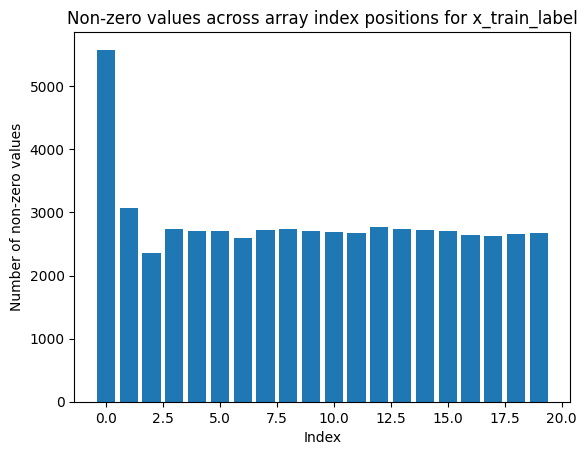

In [9]:
label_nonzeros = lumpnump.count_nonzero(X_train_label, axis=0)

# Plotting the histogram
plt.bar(range(len(label_nonzeros)), label_nonzeros)
plt.xlabel('Index')
plt.ylabel('Number of non-zero values')
plt.title('Non-zero values across array index positions for x_train_label')
plt.show()

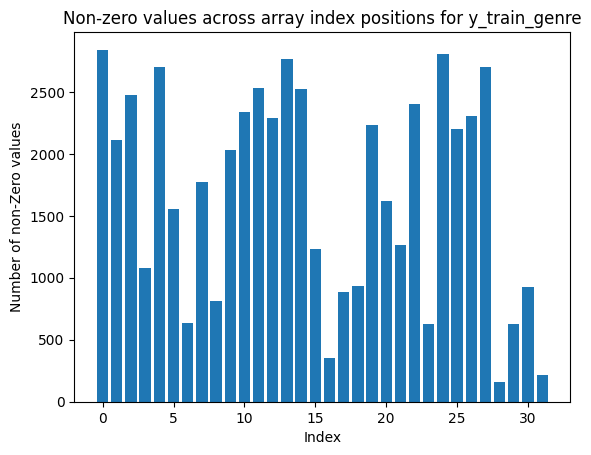

In [10]:
genre_nonzeros = lumpnump.count_nonzero(y_train_genre, axis=0)

# Plotting the histogram
plt.bar(range(len(genre_nonzeros)), genre_nonzeros)
plt.xlabel('Index')
plt.ylabel('Number of non-Zero values')
plt.title('Non-zero values across array index positions for y_train_genre')
plt.show()

In [ ]:
# def pogi_prep(input_shape):
#     soigneur = Sequential([
#         Input(shape=(input_shape,)),
#         Dense(25, activation='relu', kernel_regularizer=l2(0.01)),
#         Dense(17, activation='relu', kernel_regularizer=l2(0.01)),
#     ])
#     return soigneur

In [11]:
def pogi_prep(input_shape):
    soigneur = Sequential([
        Input(shape=(input_shape,)),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.2),  # Add dropout to reduce overfitting
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    ])
    return soigneur

In [15]:
def pogi_slay():
    label_input = Input(shape=(20,), name='label_percent_interval')  
    key_input = Input(shape=(34,), name='key')  
    mode_input = Input(shape=(3,), name='mode')  
    release_year_input = Input(shape=(4,), name='release_year')  # One-hot encoded with 4 categories

    # uae pogi_prep to create subnetwork for each input
    label_features = pogi_prep(20)(label_input)
    key_features = pogi_prep(34)(key_input)
    mode_features = pogi_prep(3)(mode_input)
    release_year_features = pogi_prep(4)(release_year_input)

    # string together the different features for use in combined model
    false_flat = Concatenate()([label_features, key_features, mode_features, release_year_features])

    # combined model hidden layers
    dolly_hidden = Dense(13, activation='relu', kernel_regularizer=l2(0.1))(false_flat)
    pogi_hidden = Dense(10, activation='relu', kernel_regularizer=l2(0.1))(dolly_hidden)

    # final outputs

    #32 genres
    genre_slay = Dense(32, activation='softmax', name='genre_id')(pogi_hidden)  
    
    # 8 BPM groups created
    bpm_4tofloor = Dense(8, activation='softmax', name='bpm_group')(pogi_hidden) 

    #single output ranging from 0 to 1 on continuous scale
    valence_smile = Dense(1, activation='sigmoid', name='valence')(pogi_hidden)  # Regression-like output for valence

    # defines final model
    pogi_wheels = Model(inputs=[label_input, key_input, mode_input, release_year_input], 
                        outputs=[genre_slay, bpm_4tofloor, valence_smile])

    return pogi_wheels

In [16]:
#executes and compiles final model
ventoux_summit = pogi_slay()

ventoux_summit.compile(
    #adamds optimizer alllows for automatic adjustments of learning rate in gradient descent instead of having to try a bunch of options
    optimizer=Adam(learning_rate=0.0001, epsilon=1e-07),
    loss={
        'genre_id': CategoricalCrossentropy(),  
        'bpm_group': CategoricalCrossentropy(),  
        'valence': MeanSquaredError() 
    },
    metrics={
        'genre_id': ['accuracy', Precision(), Recall()],
        'bpm_group': ['accuracy', Precision(), Recall()],
        'valence': 'mean_squared_error'
    }
)

2024-08-21 21:27:51.155352: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-21 21:27:51.155400: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 128.00 GB
2024-08-21 21:27:51.155411: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 48.00 GB
2024-08-21 21:27:51.155447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-21 21:27:51.155469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### model run

In [17]:
pogi_stem = f'{bucket_file_base}/silent_ascent_files/pogi_logs'
pogi_logger = f'{pogi_stem}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-ventoux_summit'

pogi_monitoring = TensorBoard(log_dir=pogi_logger, histogram_freq=1)
#fitting
pogi_soar = ventoux_summit.fit(
    [X_train_label, X_train_key, X_train_mode, X_train_year], 
    {'genre_id': y_train_genre, 'bpm_group': y_train_bpm, 'valence': y_train_valence}, 
    epochs=10, 
    batch_size=100,
     validation_data=(
     [X_cv_label, X_cv_key, X_cv_mode, X_cv_year], 
     {'genre_id': y_cv_genre, 'bpm_group': y_cv_bpm, 'valence': y_cv_valence}
        ),
    callbacks=[pogi_monitoring]
    )

Epoch 1/10


2024-08-21 21:28:01.389871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


540/540 ━━━━━━━━━━━━━━━━━━━━ 54s 92ms/step - bpm_group_accuracy: 0.2136 - bpm_group_precision_1: 0.0000e+00 - bpm_group_recall_1: 0.0000e+00 - genre_id_accuracy: 0.0510 - genre_id_precision: 0.0000e+00 - genre_id_recall: 0.0000e+00 - loss: 13.4839 - valence_mean_squared_error: 0.0095 - val_bpm_group_accuracy: 0.4175 - val_bpm_group_precision_1: 0.0000e+00 - val_bpm_group_recall_1: 0.0000e+00 - val_genre_id_accuracy: 0.0563 - val_genre_id_precision: 0.0000e+00 - val_genre_id_recall: 0.0000e+00 - val_loss: 9.7831 - val_valence_mean_squared_error: 0.0095
Epoch 2/10
540/540 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - bpm_group_accuracy: 0.4229 - bpm_group_precision_1: 0.0000e+00 - bpm_group_recall_1: 0.0000e+00 - genre_id_accuracy: 0.0493 - genre_id_precision: 0.0000e+00 - genre_id_recall: 0.0000e+00 - loss: 8.9975 - valence_mean_squared_error: 0.0092 - val_bpm_group_accuracy: 0.4175 - val_bpm_group_precision_1: 0.0000e+00 - val_bpm_group_recall_1: 0.0000e+00 - val_genre_id_accuracy: 0.0563 - val

In [ ]:
# pogi_stem = f'{bucket_file_base}/silent_ascent_files/pogi_logs'
# pogi_logger = f'{pogi_stem}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-ventoux_summit'

# pogi_monitoring = TensorBoard(log_dir=pogi_logger, histogram_freq=1)

# #fitting
# pogi_soar = ventoux_summit.fit(
#     [X_train_label, X_train_key, X_train_mode, X_train_year], 
#     {'genre_id': y_train_genre, 'bpm_group': y_train_bpm, 'valence': y_train_valence}, 
#     sample_weight=sample_weights,  # Apply sample weights here
#     epochs=10, 
#     batch_size=100,
#     validation_data=(
#         [X_cv_label, X_cv_key, X_cv_mode, X_cv_year], 
#         {'genre_id': y_cv_genre, 'bpm_group': y_cv_bpm, 'valence': y_cv_valence}
#     ),
#     callbacks=[pogi_monitoring]
# )

### plot predict

In [18]:
predictions = ventoux_summit.predict([X_test_label, X_test_key, X_test_mode, X_test_year])

563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [19]:
ventoux_evaluation = ventoux_summit.evaluate(
    [X_test_label, X_test_key, X_test_mode, X_test_year], 
    {'genre_id': y_test_genre, 'bpm_group': y_test_bpm, 'valence': y_test_valence}
)

563/563 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - bpm_group_accuracy: 0.4164 - bpm_group_precision_1: 0.0000e+00 - bpm_group_recall_1: 0.0000e+00 - genre_id_accuracy: 0.0534 - genre_id_precision: 0.0000e+00 - genre_id_recall: 0.0000e+00 - loss: 5.0462 - valence_mean_squared_error: 0.0094


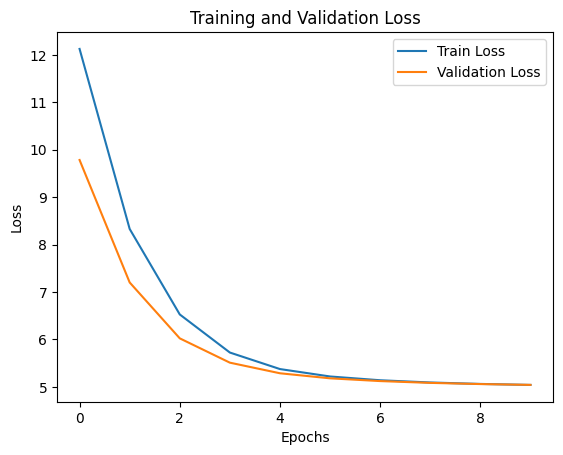

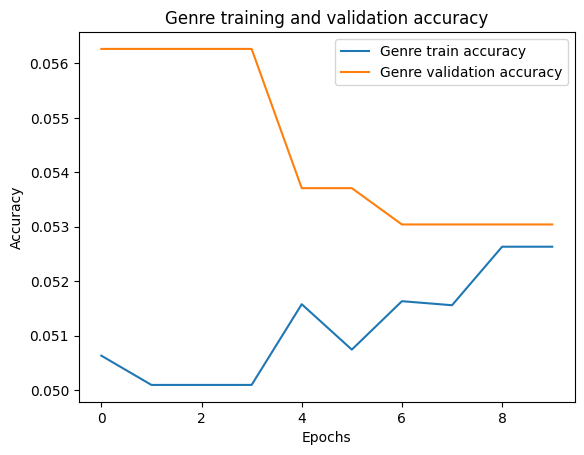

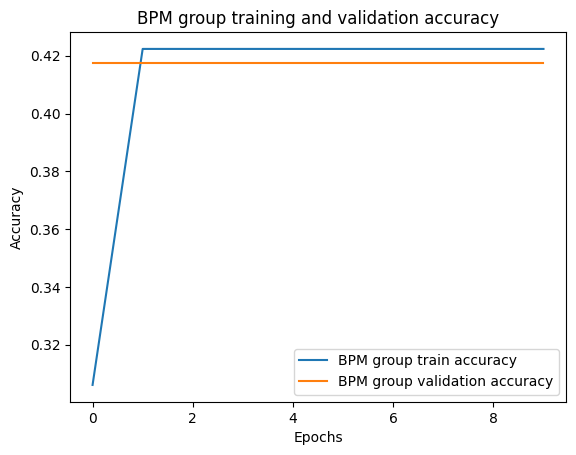

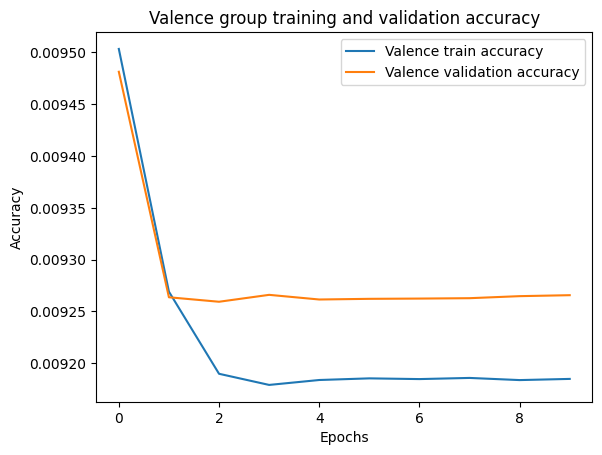

In [20]:
history = pogi_soar.history

# Plot training & validation loss values
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# You can also plot the metrics for each output (genre_id, bpm_group, valence)
plt.plot(history['genre_id_accuracy'], label='Genre train accuracy')
plt.plot(history['val_genre_id_accuracy'], label='Genre validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Genre training and validation accuracy')
plt.legend()
plt.show()

plt.plot(history['bpm_group_accuracy'], label='BPM group train accuracy')
plt.plot(history['val_bpm_group_accuracy'], label='BPM group validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BPM group training and validation accuracy')
plt.legend()
plt.show()

plt.plot(history['valence_mean_squared_error'], label='Valence train accuracy')
plt.plot(history['val_valence_mean_squared_error'], label='Valence validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Valence group training and validation accuracy')
plt.legend()
plt.show()


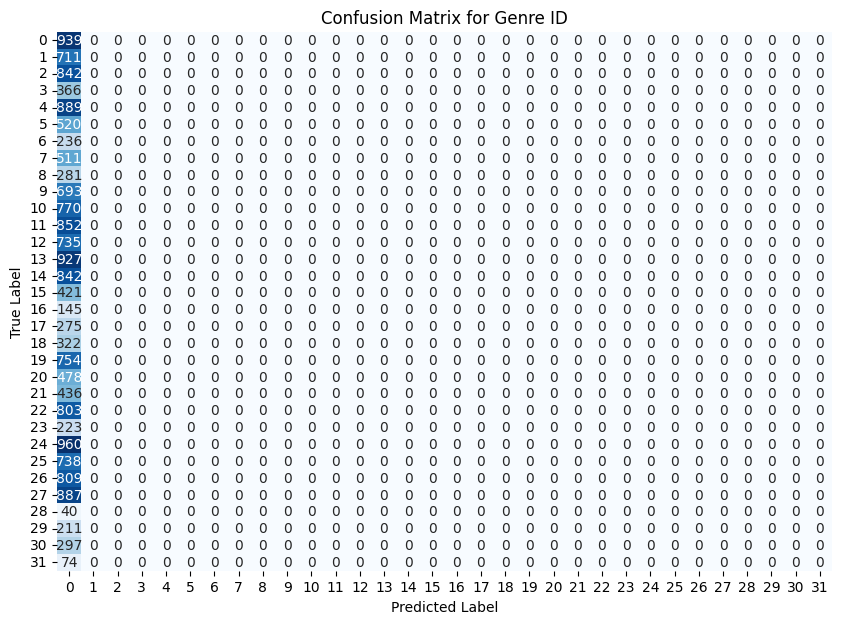

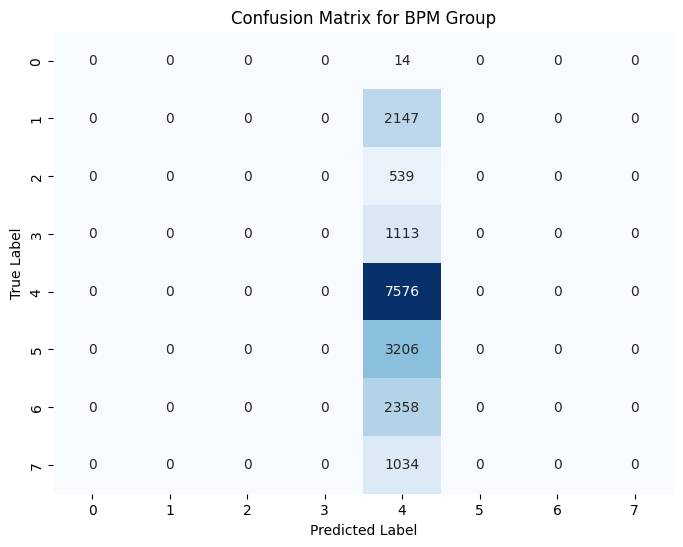

In [21]:
#predited and actual genre and bpm group values
y_pred_genre = lumpnump.argmax(predictions[0], axis=1) 
y_true_genre = lumpnump.argmax(y_test_genre, axis=1)

y_pred_bpm = lumpnump.argmax(predictions[1], axis=1) 
y_true_bpm = lumpnump.argmax(y_test_bpm, axis=1) 

# confusion matrices for genre and bpm group
cm_genre = confusion_matrix(y_true_genre, y_pred_genre)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_genre, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Genre ID')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot confusion matrix for bpm_group
cm_bpm = confusion_matrix(y_true_bpm, y_pred_bpm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bpm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for BPM Group')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


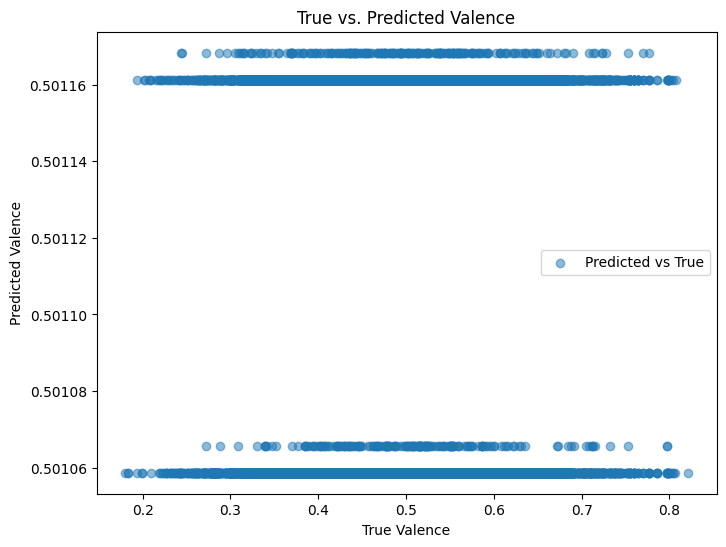

In [22]:
#prediction and actual values for valence
y_pred_valence = predictions[2].flatten() 
y_true_valence = y_test_valence 

plt.figure(figsize=(8, 6))
plt.scatter(y_true_valence, y_pred_valence, alpha=0.5, label='Predicted vs True')
plt.xlabel('True Valence')
plt.ylabel('Predicted Valence')
plt.title('True vs. Predicted Valence')
plt.legend()
plt.show()

In [ ]:
# two_layer_inputs = [1, 2, 6, 7]
# inputs = pogi_soar_matrix[:, two_layer_inputs]

# # genre ID, bpm_group, valence as targets
# two_layer_targets = [3, 5, 8]
# targets = pogi_soar_matrix[:, two_layer_targets]

# # Get unique categories (sanity check)
# year_uniques = set(inputs[:, 0])
# label_percent_uniques = set(inputs[:, 1])
# key_uniques = set(inputs[:, 2])
# mode_uniques = set(inputs[:, 3])

# print(f'input years: {year_uniques}')
# print(f'input label %: {label_percent_uniques}')
# print(f'input keys: {key_uniques}')
# print(f'input modes: {mode_uniques}')

# genre_uniques = set(targets[:, 0])
# bpm_uniques = set(targets[:, 1])
# valence_uniques = list(set(targets[:, 2]))

# print(f'target genres: {genre_uniques}')
# print(f'target bpms: {bpm_uniques}')
# print(f'target valence (example): {valence_uniques[:10]}')

# def quantile_transform_data(data):
#     transformer = QuantileTransformer(output_distribution='normal')
#     return transformer.fit_transform(data.reshape(-1, 1)).flatten()

# # valence quantile transform
# valence_index = two_layer_targets.index(8)
# valence_data = targets[:, valence_index]
# valence_transformed = quantile_transform_data(valence_data)
# targets[:, valence_index] = valence_transformed

# # transformers for categorical and numerical data
# categorical_transformer = OneHotEncoder(sparse_output=False)
# numerical_transformer = MinMaxScaler()

# input_preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', categorical_transformer, [0, 1, 2, 3])  
#     ]
# )

# target_preprocessor = ColumnTransformer(
#     transformers=[
#         ('categorical', categorical_transformer, [0, 1]), 
#         ('numerical', numerical_transformer, [2])       
#     ]
# )

# # check original shape
# print("Original matrix shape:", pogi_soar_matrix.shape)

# # transform inputs and outputs
# inputs_transformed = input_preprocessor.fit_transform(inputs)
# print("Transformed inputs shape:", inputs_transformed.shape)

# targets_transformed = target_preprocessor.fit_transform(targets)
# print("Transformed targets shape:", targets_transformed.shape)

# # train/validate/test split
# X_train, X_temp, y_train, y_temp = train_test_split(inputs_transformed, targets_transformed, test_size=0.40, random_state=1)
# X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=1)


# # train, validate, and test input sets based on where each feature lies as columns in the 61 columns of encoded matrix
# X_train_year = X_train[:, :4]  
# X_train_label = X_train[:, 4:24]  
# X_train_key = X_train[:, 24:58] 
# X_train_mode = X_train[:, 58:] 

# X_cv_year = X_cv[:, :4]
# X_cv_label = X_cv[:, 4:24]
# X_cv_key = X_cv[:, 24:58]
# X_cv_mode = X_cv[:, 58:]

# X_test_year = X_test[:, :4]
# X_test_label = X_test[:, 4:24]
# X_test_key = X_test[:, 24:58]
# X_test_mode = X_test[:, 58:]

# # train, validate, and test output sets based on where each feature lies as columns in the 61 columns of encoded matrix
# y_train_genre = y_train[:, :len(genre_uniques)]
# y_train_bpm = y_train[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_train_valence = y_train[:, -1]  # Last column for valence

# y_cv_genre = y_cv[:, :len(genre_uniques)]
# y_cv_bpm = y_cv[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_cv_valence = y_cv[:, -1]

# y_test_genre = y_test[:, :len(genre_uniques)]
# y_test_bpm = y_test[:, len(genre_uniques):(len(genre_uniques) + len(bpm_uniques))]
# y_test_valence = y_test[:, -1]

# def pogi_prep(input_shape):
#     soigneur = Sequential([
#         Input(shape=(input_shape,)),
#         Dense(25, activation='relu', kernel_regularizer=l2(0.01)),
#         Dense(17, activation='relu', kernel_regularizer=l2(0.01)),
#     ])
#     return soigneur

# def pogi_slay():
#     label_input = Input(shape=(20,), name='label_percent_interval')  
#     key_input = Input(shape=(34,), name='key')  
#     mode_input = Input(shape=(3,), name='mode')  
#     release_year_input = Input(shape=(4,), name='release_year')  # One-hot encoded with 4 categories

#     # uae pogi_prep to create subnetwork for each input
#     label_features = pogi_prep(20)(label_input)
#     key_features = pogi_prep(34)(key_input)
#     mode_features = pogi_prep(3)(mode_input)
#     release_year_features = pogi_prep(4)(release_year_input)

#     # string together the different features for use in combined model
#     false_flat = Concatenate()([label_features, key_features, mode_features, release_year_features])

#     # combined model hidden layers
#     dolly_hidden = Dense(13, activation='relu', kernel_regularizer=l2(0.1))(false_flat)
#     pogi_hidden = Dense(10, activation='relu', kernel_regularizer=l2(0.1))(dolly_hidden)

#     # final outputs

#     #32 genres
#     genre_slay = Dense(32, activation='softmax', name='genre_id')(pogi_hidden)  
    
#     # 8 BPM groups created
#     bpm_4tofloor = Dense(8, activation='softmax', name='bpm_group')(pogi_hidden) 

#     #single output ranging from 0 to 1 on continuous scale
#     valence_smile = Dense(1, activation='sigmoid', name='valence')(pogi_hidden)  # Regression-like output for valence

#     # defines final model
#     pogi_wheels = Model(inputs=[label_input, key_input, mode_input, release_year_input], 
#                         outputs=[genre_slay, bpm_4tofloor, valence_smile])

#     return pogi_wheels

# #executes and compiles final model
# ventoux_summit = pogi_slay()

# ventoux_summit.compile(
#     #adamds optimizer alllows for automatic adjustments of learning rate in gradient descent instead of having to try a bunch of options
#     optimizer=Adam(learning_rate=0.001),
#     loss={
#         'genre_id': CategoricalCrossentropy(),  
#         'bpm_group': CategoricalCrossentropy(),  
#         'valence': MeanSquaredError() 
#     },
#     metrics={
#         'genre_id': ['accuracy', Precision(), Recall()],
#         'bpm_group': ['accuracy', Precision(), Recall()],
#         'valence': 'mean_squared_error'
#     }
# )

# pogi_stem = f'{bucket_file_base}/silent_ascent_files/pogi_logs'
# pogi_logger = f'{pogi_stem}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}-ventoux_summit'

# pogi_monitoring = TensorBoard(log_dir=pogi_logger, histogram_freq=1)

# #fitting
# pogi_soar = ventoux_summit.fit(
#     [X_train_label, X_train_key, X_train_mode, X_train_year], 
#     {'genre_id': y_train_genre, 'bpm_group': y_train_bpm, 'valence': y_train_valence}, 
#     epochs=10, 
#     batch_size=100,
#      validation_data=(
#      [X_cv_label, X_cv_key, X_cv_mode, X_cv_year], 
#      {'genre_id': y_cv_genre, 'bpm_group': y_cv_bpm, 'valence': y_cv_valence}
#         ),
#     callbacks=[pogi_monitoring]
#     )
# predictions = ventoux_summit.predict([X_test_label, X_test_key, X_test_mode, X_test_year])

# ventoux_evaluation = ventoux_summit.evaluate(
#     [X_test_label, X_test_key, X_test_mode, X_test_year], 
#     {'genre_id': y_test_genre, 'bpm_group': y_test_bpm, 'valence': y_test_valence}
# )

# #predited and actual genre and bpm group values
# y_pred_genre = lumpnump.argmax(predictions[0], axis=1) 
# y_true_genre = lumpnump.argmax(y_test_genre, axis=1)

# y_pred_bpm = lumpnump.argmax(predictions[1], axis=1) 
# y_true_bpm = lumpnump.argmax(y_test_bpm, axis=1) 

# # confusion matrices for genre and bpm group
# cm_genre = confusion_matrix(y_true_genre, y_pred_genre)
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm_genre, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix for Genre ID')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()

# # Plot confusion matrix for bpm_group
# cm_bpm = confusion_matrix(y_true_bpm, y_pred_bpm)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_bpm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title('Confusion Matrix for BPM Group')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.show()
